In [1]:
!python3.6 -m pip install tensorboardX
!python3.6 -m pip install torch
!python3.6 -m pip install librosa
!apt-get install libsndfile1 --yes

     |████████████████████████████████| 204kB 1.0MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 734.6MB 121kB/s  eta 0:00:01     |████████████▏                   | 280.4MB 10.7MB/s eta 0:00:43████████████████████████      | 596.5MB 12.0MB/s eta 0:00:12     |██████████████████████████▌     | 608.7MB 10.6MB/s eta 0:00:12��██████████████▌   | 654.4MB 12.2MB/s eta 0:00:07
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 1.6MB 1.0MB/s eta 0:00:01
     |████████████████████████████████| 26.1MB 10.7MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 11.5MB/s eta 0:00:01
     |████████████████████████████████| 296kB 7.5MB/s eta 0:00:01
     |████████████████████████████████| 327kB 13.9MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 13.1MB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 11.2MB/s eta 0:00:01


debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libogg0:amd64.
(Reading database ... 15402 files and directories currently installed.)
Preparing to unpack .../libogg0_1.3.2-1_amd64.deb ...
Unpacking libogg0:amd64 (1.3.2-1) ...
Selecting previously unselected package libflac8:amd64.
Preparing to unpack .../libflac8_1.3.2-1_amd64.deb ...
Unpacking libflac8:amd64 (1.3.2-1) ...
Selecting previously unselected package libvorbis0a:amd64.
Preparing to unpack .../libvorbis0a_1.3.5-4.2_amd64.deb ...
Unpacking libvorbis0a:amd64 (1.3.5-4.2) ...
Selecting previously unselected package libvorbisenc2:amd64.
Preparing to unpack .../libvorbisenc2_1.3.5-4.2_amd64.deb ...
Unpacking libvorbisenc2:amd64 (1.3.5-4.2) ...
Selecting previously unselected package libsndfile1:amd64.
Preparing to unpack .../libsndfile1_1.0.28-4ubuntu0.18.04.1_amd64.deb ...
Unpacking libsndfile1:amd64 (1.0.28-4ubuntu0.18.04.1) ...
Setting up libogg0:amd64 (1.3.2-1)

# Test code copy

load model from model_vctk/model_vctk-0
(513, 165) (513, 171)


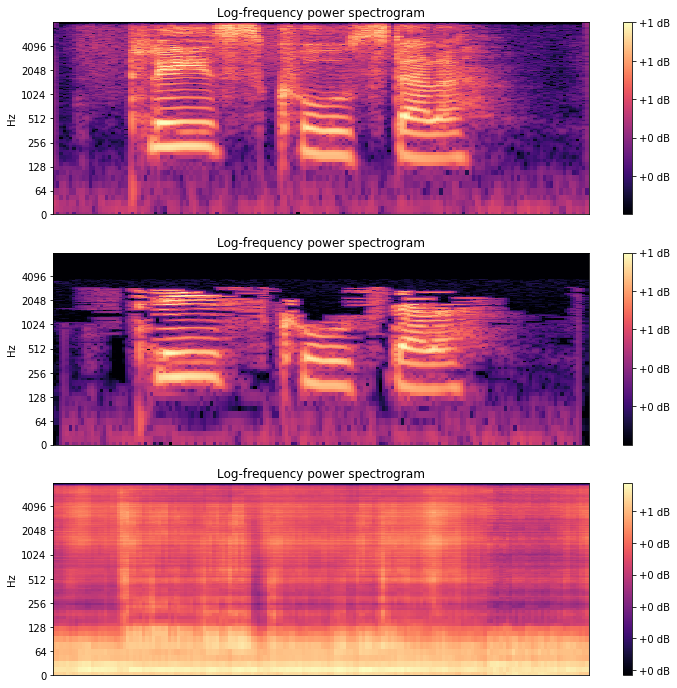

In [3]:
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import pickle
from utils import Hps
from preprocess.tacotron.norm_utils import spectrogram2wav, get_spectrograms
from scipy.io.wavfile import write
import glob
import os
from solver import Solver
import librosa
import librosa.display
from plots import plot
%matplotlib inline

args_hps='vctk.json'
args_model="model_vctk/model_vctk-0"
args_source="test/p225_001.wav"
args_source_8="test/p225_001-8.wav"
args_target=18
args_output="test/output.wav"
args_sample_rate=16000
args_use_gen=False

hps = Hps()
hps.load(args_hps)
hps_tuple = hps.get_tuple()
solver = Solver(hps_tuple, None)
solver.load_model(args_model)
_, spec = get_spectrograms(args_source)
_, spec_8 = get_spectrograms(args_source_8)

spec_expand = np.expand_dims(spec, axis=0)
spec_tensor = torch.from_numpy(spec_expand).type(torch.FloatTensor)
c = Variable(torch.from_numpy(np.array([int(args_target)]))).cuda()
result = solver.test_step(spec_tensor, c, gen=args_use_gen)
result = result.squeeze(axis=0).transpose((1, 0))
wav_data = spectrogram2wav(result)
write(args_output, rate=args_sample_rate, data=wav_data)

plot(spec.T, spec_8.T, result.T)

# Train code copy

In [ ]:
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import pickle
from utils import Hps
from utils import DataLoader
from utils import Logger
from utils import SingleDataset
from solver import Solver
import argparse
%matplotlib inline

args_load_model=False #todo train rest? musiałbym odpalić bez pretrain i zmodyfikować 
#iterację (dodać ileś przed pętlą) i ręcznie zatrzymać po 80k
args_flag='train'
args_hps_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk.json"
args_dataset_path_trg="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/data.h5"
args_dataset_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/data-8.h5"
args_index_path_trg="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/index.json"
args_index_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/index.json"
args_output_model_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/model_vctk/model_vctk"
args_load_model_path="model_vctk/model_vctk-0"

hps = Hps()
hps.load(args_hps_path)
hps_tuple = hps.get_tuple()
dataset = SingleDataset(args_dataset_path, args_index_path, seg_len=hps_tuple.seg_len)
dataset_trg = SingleDataset(args_dataset_path_trg, args_index_path_trg, seg_len=hps_tuple.seg_len)
data_loader = DataLoader(dataset, dataset_trg)

solver = Solver(hps_tuple, data_loader)
if args_load_model:
    solver.load_model(args_load_model_path)

solver.train(args_output_model_path, args_flag, mode='pretrain_G')
solver.train(args_output_model_path, args_flag, mode='pretrain_D')
solver.train(args_output_model_path, args_flag, mode='train')
solver.train(args_output_model_path, args_flag, mode='patchGAN')

pre_G:[000001/008000], loss_rec=0.478
pre_G:[000002/008000], loss_rec=0.457
pre_G:[000003/008000], loss_rec=0.416
pre_G:[000004/008000], loss_rec=0.429
pre_G:[000005/008000], loss_rec=0.396
pre_G:[000006/008000], loss_rec=0.388
pre_G:[000007/008000], loss_rec=0.362
pre_G:[000008/008000], loss_rec=0.373
pre_G:[000009/008000], loss_rec=0.339
pre_G:[000010/008000], loss_rec=0.335
pre_G:[000011/008000], loss_rec=0.320
pre_G:[000012/008000], loss_rec=0.316
pre_G:[000013/008000], loss_rec=0.303
pre_G:[000014/008000], loss_rec=0.294
pre_G:[000015/008000], loss_rec=0.292
pre_G:[000016/008000], loss_rec=0.272
pre_G:[000017/008000], loss_rec=0.255
pre_G:[000018/008000], loss_rec=0.263
pre_G:[000019/008000], loss_rec=0.259
pre_G:[000020/008000], loss_rec=0.242
pre_G:[000021/008000], loss_rec=0.237
pre_G:[000022/008000], loss_rec=0.232
pre_G:[000023/008000], loss_rec=0.228
pre_G:[000024/008000], loss_rec=0.226
pre_G:[000025/008000], loss_rec=0.215
pre_G:[000026/008000], loss_rec=0.215
pre_G:[00002

pre_G:[000217/008000], loss_rec=0.097
pre_G:[000218/008000], loss_rec=0.099
pre_G:[000219/008000], loss_rec=0.102
pre_G:[000220/008000], loss_rec=0.105
pre_G:[000221/008000], loss_rec=0.108
pre_G:[000222/008000], loss_rec=0.113
pre_G:[000223/008000], loss_rec=0.100
pre_G:[000224/008000], loss_rec=0.100
pre_G:[000225/008000], loss_rec=0.100
pre_G:[000226/008000], loss_rec=0.101
pre_G:[000227/008000], loss_rec=0.101
pre_G:[000228/008000], loss_rec=0.099
pre_G:[000229/008000], loss_rec=0.106
pre_G:[000230/008000], loss_rec=0.101
pre_G:[000231/008000], loss_rec=0.102
pre_G:[000232/008000], loss_rec=0.101
pre_G:[000233/008000], loss_rec=0.098
pre_G:[000234/008000], loss_rec=0.099
pre_G:[000235/008000], loss_rec=0.099
pre_G:[000236/008000], loss_rec=0.102
pre_G:[000237/008000], loss_rec=0.098
pre_G:[000238/008000], loss_rec=0.102
pre_G:[000239/008000], loss_rec=0.107
pre_G:[000240/008000], loss_rec=0.101
pre_G:[000241/008000], loss_rec=0.102
pre_G:[000242/008000], loss_rec=0.094
pre_G:[00024

pre_G:[000435/008000], loss_rec=0.086
pre_G:[000436/008000], loss_rec=0.088
pre_G:[000437/008000], loss_rec=0.089
pre_G:[000438/008000], loss_rec=0.086
pre_G:[000439/008000], loss_rec=0.089
pre_G:[000440/008000], loss_rec=0.091
pre_G:[000441/008000], loss_rec=0.093
pre_G:[000442/008000], loss_rec=0.091
pre_G:[000443/008000], loss_rec=0.085
pre_G:[000444/008000], loss_rec=0.086
pre_G:[000445/008000], loss_rec=0.084
pre_G:[000446/008000], loss_rec=0.083
pre_G:[000447/008000], loss_rec=0.084
pre_G:[000448/008000], loss_rec=0.086
pre_G:[000449/008000], loss_rec=0.088
pre_G:[000450/008000], loss_rec=0.088
pre_G:[000451/008000], loss_rec=0.090
pre_G:[000452/008000], loss_rec=0.092
pre_G:[000453/008000], loss_rec=0.089
pre_G:[000454/008000], loss_rec=0.090
pre_G:[000455/008000], loss_rec=0.090
pre_G:[000456/008000], loss_rec=0.086
pre_G:[000457/008000], loss_rec=0.088
pre_G:[000458/008000], loss_rec=0.087
pre_G:[000459/008000], loss_rec=0.086
pre_G:[000460/008000], loss_rec=0.092
pre_G:[00046

pre_G:[000651/008000], loss_rec=0.084
pre_G:[000652/008000], loss_rec=0.084
pre_G:[000653/008000], loss_rec=0.086
pre_G:[000654/008000], loss_rec=0.089
pre_G:[000655/008000], loss_rec=0.090
pre_G:[000656/008000], loss_rec=0.085
pre_G:[000657/008000], loss_rec=0.081
pre_G:[000658/008000], loss_rec=0.087
pre_G:[000659/008000], loss_rec=0.081
pre_G:[000660/008000], loss_rec=0.081
pre_G:[000661/008000], loss_rec=0.085
pre_G:[000662/008000], loss_rec=0.088
pre_G:[000663/008000], loss_rec=0.082
pre_G:[000664/008000], loss_rec=0.083
pre_G:[000665/008000], loss_rec=0.080
pre_G:[000666/008000], loss_rec=0.084
pre_G:[000667/008000], loss_rec=0.086
pre_G:[000668/008000], loss_rec=0.086
pre_G:[000669/008000], loss_rec=0.082
pre_G:[000670/008000], loss_rec=0.083
pre_G:[000671/008000], loss_rec=0.078
pre_G:[000672/008000], loss_rec=0.080
pre_G:[000673/008000], loss_rec=0.085
pre_G:[000674/008000], loss_rec=0.083
pre_G:[000675/008000], loss_rec=0.085
pre_G:[000676/008000], loss_rec=0.078
pre_G:[00067

pre_G:[000869/008000], loss_rec=0.073
pre_G:[000870/008000], loss_rec=0.079
pre_G:[000871/008000], loss_rec=0.077
pre_G:[000872/008000], loss_rec=0.086
pre_G:[000873/008000], loss_rec=0.080
pre_G:[000874/008000], loss_rec=0.076
pre_G:[000875/008000], loss_rec=0.080
pre_G:[000876/008000], loss_rec=0.082
pre_G:[000877/008000], loss_rec=0.077
pre_G:[000878/008000], loss_rec=0.079
pre_G:[000879/008000], loss_rec=0.083
pre_G:[000880/008000], loss_rec=0.079
pre_G:[000881/008000], loss_rec=0.084
pre_G:[000882/008000], loss_rec=0.081
pre_G:[000883/008000], loss_rec=0.079
pre_G:[000884/008000], loss_rec=0.083
pre_G:[000885/008000], loss_rec=0.085
pre_G:[000886/008000], loss_rec=0.083
pre_G:[000887/008000], loss_rec=0.084
pre_G:[000888/008000], loss_rec=0.083
pre_G:[000889/008000], loss_rec=0.080
pre_G:[000890/008000], loss_rec=0.077
pre_G:[000891/008000], loss_rec=0.081
pre_G:[000892/008000], loss_rec=0.077
pre_G:[000893/008000], loss_rec=0.081
pre_G:[000894/008000], loss_rec=0.080
pre_G:[00089

pre_G:[001085/008000], loss_rec=0.082
pre_G:[001086/008000], loss_rec=0.078
pre_G:[001087/008000], loss_rec=0.077
pre_G:[001088/008000], loss_rec=0.080
pre_G:[001089/008000], loss_rec=0.076
pre_G:[001090/008000], loss_rec=0.079
pre_G:[001091/008000], loss_rec=0.078
pre_G:[001092/008000], loss_rec=0.077
pre_G:[001093/008000], loss_rec=0.077
pre_G:[001094/008000], loss_rec=0.080
pre_G:[001095/008000], loss_rec=0.078
pre_G:[001096/008000], loss_rec=0.076
pre_G:[001097/008000], loss_rec=0.078
pre_G:[001098/008000], loss_rec=0.083
pre_G:[001099/008000], loss_rec=0.078
pre_G:[001100/008000], loss_rec=0.075
pre_G:[001101/008000], loss_rec=0.076
pre_G:[001102/008000], loss_rec=0.075
pre_G:[001103/008000], loss_rec=0.079
pre_G:[001104/008000], loss_rec=0.074
pre_G:[001105/008000], loss_rec=0.078
pre_G:[001106/008000], loss_rec=0.074
pre_G:[001107/008000], loss_rec=0.077
pre_G:[001108/008000], loss_rec=0.071
pre_G:[001109/008000], loss_rec=0.076
pre_G:[001110/008000], loss_rec=0.077
pre_G:[00111

pre_G:[001301/008000], loss_rec=0.074
pre_G:[001302/008000], loss_rec=0.071
pre_G:[001303/008000], loss_rec=0.074
pre_G:[001304/008000], loss_rec=0.078
pre_G:[001305/008000], loss_rec=0.079
pre_G:[001306/008000], loss_rec=0.074
pre_G:[001307/008000], loss_rec=0.078
pre_G:[001308/008000], loss_rec=0.075
pre_G:[001309/008000], loss_rec=0.077
pre_G:[001310/008000], loss_rec=0.076
pre_G:[001311/008000], loss_rec=0.073
pre_G:[001312/008000], loss_rec=0.076
pre_G:[001313/008000], loss_rec=0.076
pre_G:[001314/008000], loss_rec=0.074
pre_G:[001315/008000], loss_rec=0.080
pre_G:[001316/008000], loss_rec=0.080
pre_G:[001317/008000], loss_rec=0.076
pre_G:[001318/008000], loss_rec=0.078
pre_G:[001319/008000], loss_rec=0.079
pre_G:[001320/008000], loss_rec=0.072
pre_G:[001321/008000], loss_rec=0.077
pre_G:[001322/008000], loss_rec=0.074
pre_G:[001323/008000], loss_rec=0.074
pre_G:[001324/008000], loss_rec=0.075
pre_G:[001325/008000], loss_rec=0.075
pre_G:[001326/008000], loss_rec=0.077
pre_G:[00132

pre_G:[001517/008000], loss_rec=0.075
pre_G:[001518/008000], loss_rec=0.077
pre_G:[001519/008000], loss_rec=0.074
pre_G:[001520/008000], loss_rec=0.072
pre_G:[001521/008000], loss_rec=0.078
pre_G:[001522/008000], loss_rec=0.074
pre_G:[001523/008000], loss_rec=0.074
pre_G:[001524/008000], loss_rec=0.080
pre_G:[001525/008000], loss_rec=0.077
pre_G:[001526/008000], loss_rec=0.073
pre_G:[001527/008000], loss_rec=0.079
pre_G:[001528/008000], loss_rec=0.074
pre_G:[001529/008000], loss_rec=0.076
pre_G:[001530/008000], loss_rec=0.076
pre_G:[001531/008000], loss_rec=0.075
pre_G:[001532/008000], loss_rec=0.074
pre_G:[001533/008000], loss_rec=0.067
pre_G:[001534/008000], loss_rec=0.073
pre_G:[001535/008000], loss_rec=0.069
pre_G:[001536/008000], loss_rec=0.073
pre_G:[001537/008000], loss_rec=0.075
pre_G:[001538/008000], loss_rec=0.076
pre_G:[001539/008000], loss_rec=0.075
pre_G:[001540/008000], loss_rec=0.075
pre_G:[001541/008000], loss_rec=0.075
pre_G:[001542/008000], loss_rec=0.077
pre_G:[00154

pre_G:[001733/008000], loss_rec=0.074
pre_G:[001734/008000], loss_rec=0.071
pre_G:[001735/008000], loss_rec=0.077
pre_G:[001736/008000], loss_rec=0.075
pre_G:[001737/008000], loss_rec=0.075
pre_G:[001738/008000], loss_rec=0.075
pre_G:[001739/008000], loss_rec=0.074
pre_G:[001740/008000], loss_rec=0.077
pre_G:[001741/008000], loss_rec=0.074
pre_G:[001742/008000], loss_rec=0.075
pre_G:[001743/008000], loss_rec=0.073
pre_G:[001744/008000], loss_rec=0.074
pre_G:[001745/008000], loss_rec=0.074
pre_G:[001746/008000], loss_rec=0.071
pre_G:[001747/008000], loss_rec=0.073
pre_G:[001748/008000], loss_rec=0.080
pre_G:[001749/008000], loss_rec=0.074
pre_G:[001750/008000], loss_rec=0.075
pre_G:[001751/008000], loss_rec=0.075
pre_G:[001752/008000], loss_rec=0.075
pre_G:[001753/008000], loss_rec=0.077
pre_G:[001754/008000], loss_rec=0.072
pre_G:[001755/008000], loss_rec=0.074
pre_G:[001756/008000], loss_rec=0.072
pre_G:[001757/008000], loss_rec=0.069
pre_G:[001758/008000], loss_rec=0.075
pre_G:[00175